# Qiskit Assignment 2

## Elitzur-Vaidman Bomb

### Learning Objectives
1. Implement the EV Bomb experiment
2. Run the experiment on an IBM quantum computer

### Resources
Qiskit assignments are designed to be collaborative and open internet. Where possible, links to useful documentation will be embedded within questions. You're free to discuss these tasks with TAs and peers, but do write your own solutions. For some questions, there may be additional restrictions on the ways you can solve them. To ensure compliance with course policies and assignment instructions, we reserve the right to inspect your code.

**NAME**: REPLACE WITH YOUR NAME

**STUDENT ID**: REPLACE WITH YOUR STUDENT ID

In [1]:
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import re

#### Task 1 - Establishing the Required Iterations (10 pts)
First let's compute the number of iterations through the loop we need to be arbitrarily confident that there won't be an explosion during our experiment. 
- write a function `compute_iterations` that takes an input `probability`, *in decimal form*
- return `n`, the number of iterations needed to be (`probability`$\times 100$)% confident that there will **not** be an explosion
- round $n$ to the next highest integer. 

In [2]:
def compute_iterations(probability):
    # BEGIN SOLUTION
    n = (np.pi**2) / (4*(1-probability))
    return round(n)
    # END SOLUTION

In [3]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: Wrong answer.
""" # END TEST CONFIG
compute_iterations(0.5) == 5

True

In [4]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: Wrong answer.
""" # END TEST CONFIG
compute_iterations(0.99) == 247

True

In [5]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: Wrong answer.
""" # END TEST CONFIG
compute_iterations(0.99473) == 468

True

In [6]:
""" # BEGIN TEST CONFIG
hidden: true
points: 7
failure_message: Wrong answer.
""" # END TEST CONFIG
def testComputeIterations():
    for n in range(1,1000):
        probability = n / 1000
        solution_ans = round((np.pi**2) / (4*(1-probability)))
        student_ans = compute_iterations(probability)
        if student_ans != solution_ans:
            return False
    return True

testComputeIterations()

True

#### Task 2 - Computing Theta (10 pts)
We know the number of iterations we need to be arbitrarily confident the bomb won't explode. Now let's calculate the angle we need to rotate through at each step of iteration, $\theta$. 
- write a function `compute_theta` that takes `n` as input
- return $\theta$, rounded to the nearest `5` decimal places.

In [7]:
def compute_theta(n):
    # BEGIN SOLUTION
    theta = round(np.pi/n,5)
    return theta
    # END SOLUTION

In [8]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: Wrong number of decimal places.
""" # END TEST CONFIG
rounding_re = re.compile(r"^([\d]{1}).([\d]{5})$")
def testNumDecimalPlaces():
    theta = compute_theta(10)
    success = True
    return False if rounding_re.match(str(theta)) is None else True
  
testNumDecimalPlaces()

True

In [9]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: Wrong answer.
""" # END TEST CONFIG
compute_theta(15) == 0.20944

True

In [10]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: Wrong answer.
""" # END TEST CONFIG
compute_theta(25) == 0.12566

True

In [11]:
""" # BEGIN TEST CONFIG
hidden: true
points: 7
failure_message: Wrong answer.
""" # END TEST CONFIG
def testComputeTheta():
    for n in range(1,1000):
        solution_ans = round(np.pi/n,5)
        student_ans = compute_theta(n)
        if student_ans != solution_ans:
            return False
    return True

testComputeTheta()

True

#### Task 3 - Rotation (10 pts)
- write a function `rotate` that takes an input QuantumCircuit `qc` and an input `theta`
- rotate the state on the first qubit by `theta` radians about the $y$-axis of the Bloch sphere
- return the modified circuit

In [12]:
def rotate(qc, theta):
    # BEGIN SOLUTION
    qc.ry(theta, 0)
    return qc
    # END SOLUTION

In [13]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: Wrong answer.
""" # END TEST CONFIG
def testProbabilities1():
    qc = QuantumCircuit(1,1)
    theta = np.pi
    qc_rot = rotate(qc, theta).reverse_bits()
    job = execute(qc_rot, BasicAer.get_backend('statevector_simulator'), shots=10)
    return list(job.result().get_statevector(qc))

testProbabilities1()  == [0,1]

True

In [14]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: Wrong answer.
""" # END TEST CONFIG
def testProbabilities2():
    qc = QuantumCircuit(1,1)
    theta = np.pi / 2
    qc_rot = rotate(qc, theta).reverse_bits()
    job = execute(qc_rot, BasicAer.get_backend('statevector_simulator'), shots=10)
    return list(job.result().get_statevector(qc))

testProbabilities2() == [1/np.sqrt(2), 1/np.sqrt(2)]

True

In [15]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: Wrong answer.
""" # END TEST CONFIG
def testProbabilities3():
    qc = QuantumCircuit(1,1)
    theta = 2 * np.pi / 3
    qc_rot = rotate(qc, theta).reverse_bits()
    job = execute(qc_rot, BasicAer.get_backend('statevector_simulator'), shots=10)
    return [round(num, 5) for num in job.result().get_statevector().real]

testProbabilities3() == [round(num, 5) for num in [1/2, np.sqrt(3)/2]]

True

In [16]:
""" # BEGIN TEST CONFIG
hidden: true
points: 7
failure_message: Wrong answer.
""" # END TEST CONFIG
def testProbabilitiesHidden():
    em = BasicAer.get_backend("qasm_simulator")
    passing = True
    for i in range(360):
        theta = i * np.pi/180
        qc_student = rotate(QuantumCircuit(1,1), theta)
        qc_solution = QuantumCircuit(1,1)
        qc_solution.u(theta, 0, 0, 0)
        equivalent = Statevector.from_instruction(qc_student).equiv(Statevector.from_instruction(qc_solution))
        if not equivalent:
            passing = False
    return passing

testProbabilitiesHidden()

True

We provide the below method `bomb_oracle` to randomly decide to include a bomb or not in our experiment.

In [17]:
random.seed(468)

def bomb_oracle():
    if random.random() < 0.5:
        return "bomb"
    else:
        return "empty"

#### Task 4  - Putting Things Together (40 pts)
We are now ready to build the full circuit.
- complete the function `gen_circuit` which takes in a probability that the bomb \*won't\* explode and the result of a call to `bomb_oracle`
- return a circuit representing the standard EV bomb implementation 

For our experiment, we will represent the presence of a bomb with a measurement and its absence with an [identity gate](https://qiskit.org/documentation/tutorials/circuits/3_summary_of_quantum_operations.html#Identity-gate). At the end of the circuit, remember to perform a final measurement to the result bit.

**Hints**: 
- use the previous tasks to help build your circuit
- make sure to consider both the `bomb` and `empty` cases
- in the case of a bomb, perform trial measurements to a distinct `step` bit
- refer to the end of the `08` lecture for a description of the implementation

In [18]:
def gen_circuit(probability, bomb):
    n = compute_iterations(probability)
    qc = QuantumCircuit(QuantumRegister(1,'qr'), 
                        ClassicalRegister(n, 'step'), 
                        ClassicalRegister(1, 'result')
                       )
    # You fill in the rest!
    # BEGIN SOLUTION
    angle = compute_theta(n)
    for i in range(n):
        rotate(qc, angle)
        if bomb == "bomb":
            qc.measure(0,i)
        else:
            qc.id(0)
            
    qc.measure(0,n)
    return qc
    # END SOLUTION

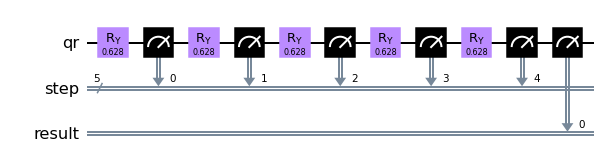

In [19]:
# Draw a bomb circuit here having probability == 0.5
# BEGIN SOLUTION
qc = gen_circuit(0.5, "bomb")
qc.draw(output='mpl')
# END SOLUTION

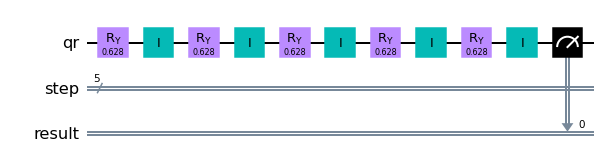

In [20]:
# Draw an empty circuit here having probability == 0.5
# BEGIN SOLUTION
qc = gen_circuit(0.5, "empty")
qc.draw(output='mpl')
# END SOLUTION

For the next task, run the code below a few times and observe the output. 

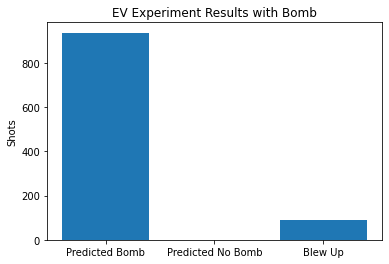

In [22]:
qasm_sim = BasicAer.get_backend("qasm_simulator")

def em(qc, shots=1024):
    job = execute(qc, qasm_sim, shots=shots)
    counts = job.result().get_counts()
    return counts

def run_circuit(percentage,bomb):
    qc = gen_circuit(percentage,bomb)
    counts = em(qc)
    n = compute_iterations(percentage)
    
    zeros_key = "0 " + "0"*n
    one_key = "1 "+"0"*n
    
    predicted_bomb = 0
    predicted_no_bomb = 0
    blew_up = 0

    if zeros_key in counts:
        predicted_bomb = counts[zeros_key]
    if one_key in counts:
        predicted_no_bomb = counts[one_key]
        
    blew_up = 1024 - predicted_bomb - predicted_no_bomb
    
    y = np.arange(3)
    plt.bar(y, [predicted_bomb, predicted_no_bomb, blew_up])
    plt.ylabel("Shots")
    plt.xticks(y, ["Predicted Bomb", "Predicted No Bomb", "Blew Up"])
    if bomb == "bomb":
        plt.title("EV Experiment Results with Bomb")
    else:
        plt.title("EV Experiment Results with No Bomb")
    plt.show()
    
    return None

bomb = bomb_oracle()
run_circuit(0.9, bomb)

#### Task 5  - Testing your Circuit (10 pts)
- what does measuring $|0\rangle$ or $|1\rangle$ each tell us about the the presence or absence of a bomb?
- does your circuit blow up a reasonable percentage of the time? (What would be a reasonable percentage?)

Be sure to save a chart in your notebook that shows this ratio for a "bomb" circuit. Describe it in your response below.

$|1\rangle$ represents the case of no bomb present. $|0\rangle$ represents the expected state when a bomb is present. If there is a bomb, we'd see it according to the 1 minus the probability parameter for the function.

The chart shows that roughly 100 out of 1024 trials resulted in an explosion with a bomb present. This is aligned with the probability set for the experiment where we wanted to not blow up 90% of the time.

#### Task 6 (6A, 6B) - EV Bomb on an IBM Quantum Computer (20 pts)
Finally, let's run this circuit on a real quantum computer. Hopefully it doesn't blow up ;)
- set the experiment probability to be `0.9`
- ensure the presence of a `bomb`
- store the measurement results in `counts`

**Note**: Do **not** use the ibmq_armonk backend for this task.

ibmqfactory.load_account:WARNING:2022-02-06 17:12:17,815: Credentials are already in use. The existing account in the session will be replaced.


Check job status here: https://quantum-computing.ibm.com/jobs/620055d5468a80bb240d732b


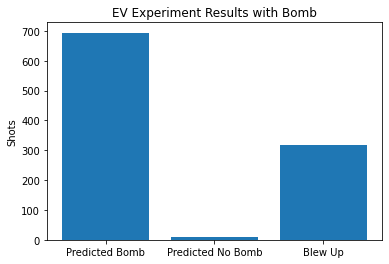

In [26]:
# run your circuit here

# BEGIN SOLUTION
IBMQ.load_account()
ibmqc = IBMQ.get_provider(hub='ibm-q').get_backend('ibmq__')
job = execute(gen_circuit(.9, "bomb"), ibmqc, shots=1024)
print("Check job status here:", "https://quantum-computing.ibm.com/jobs/" + job.job_id())
res = job.result()
counts = res.get_counts()
# END SOLUTION

# no need to edit any of this code below...
n = compute_iterations(.9)
zeros_key = "0 " + "0"*n
one_key = "1 "+ "0"*n

predicted_bomb = 0
predicted_no_bomb = 0
blew_up = 0

if zeros_key in counts:
    predicted_bomb = counts[zeros_key]
if one_key in counts:
    predicted_no_bomb = counts[one_key]

blew_up = 1024 - predicted_bomb - predicted_no_bomb

y = np.arange(3)
plt.bar(y, [predicted_bomb, predicted_no_bomb, blew_up])
plt.ylabel("Shots")
plt.xticks(y, ["Predicted Bomb", "Predicted No Bomb", "Blew Up"])
plt.title("EV Experiment Results with Bomb")
plt.show()

Did your circuit blow up a reasonable percentage of the time on the quantum computer? Save a chart in your notebook that shows this ratio and describe it in your response below. Was there any difference between the simulator and quantum computer results? If there was, what might account for it?

The ratio looks similar although there were about three times as many explosions when running on the quantum computer (at least when this solution was made) as in the simulator. This is likely caused by the noise (gate error, decoherence) inherent in the real quantum computer.

Next time: multi-qubit circuits!